**GAE IMPORT LIBRARIES, MODEL & IMAGE**

In [ ]:
!git clone https://github.com/dsgiitr/adversarial_lab

Cloning into 'adversarial_lab'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 176 (delta 82), reused 82 (delta 42), pack-reused 47
Receiving objects: 100% (176/176), 88.13 MiB | 5.25 MiB/s, done.
Resolving deltas: 100% (89/89), done.


In [ ]:
from torchvision import models
import torch
from adversarial_lab import GAE

In [ ]:
#model = models.alexnet(pretrained=True)
model = models.resnet50(pretrained=True)
#model = models.vgg19(pretrained=True)
model.eval()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from torchvision import transforms
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
from PIL import Image
img = Image.open("elephant.jpeg")

In [ ]:
img_t = transform(img)
#img_t = image4
batch_t = torch.unsqueeze(img_t, 0)

with open('adversarial_lab/imagenet_classes') as f:
    classes = [line.strip() for line in f.readlines()]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = inv_normalize(img)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

def imshow_compare(img1, img2):
    #innormalize
    pert = img2.cpu()-img1.cpu()
    img1 = inv_normalize(img1.cpu())
    img2 = inv_normalize(img2.cpu())
    pert = inv_normalize(pert)
    
    #to_numpy
    npimg1 = img1.detach().numpy()
    npimg2 = img2.detach().numpy()
    nppert = pert.detach().numpy()
    
    f, axarr = plt.subplots(1, 3)
    axarr[0].imshow(np.transpose(npimg1, (1, 2, 0)))
    axarr[1].imshow(np.transpose(nppert, (1, 2, 0)))
    axarr[2].imshow(np.transpose(npimg2, (1, 2, 0)))

    plt.show()

**FAST GRADIENT SIGN METHOD (UNTARGETED)**

In [ ]:
original_output, perturbed_output, perturbed_image = GAE.fgsm(model, batch_t, 0.25, torch.device('cuda'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


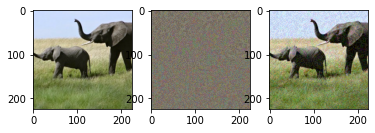

[('386, African_elephant', 95.10133361816406), ('101, tusker', 4.300267696380615), ('385, Indian_elephant', 0.5597339272499084), ('346, water_buffalo', 0.018703633919358253), ('343, warthog', 0.00771339563652873)]


[('346, water_buffalo', 38.215576171875),
 ('386, African_elephant', 24.056676864624023),
 ('101, tusker', 5.519506931304932),
 ('343, warthog', 3.071927785873413),
 ('134, crane', 1.840749979019165)]

In [ ]:
imshow_compare(batch_t[0], perturbed_image[0])
#original output
or_percentage = torch.nn.functional.softmax(original_output, dim=1)[0] * 100
_, or_indices = torch.sort(original_output, descending=True)
print([(classes[idx], or_percentage[idx].item()) for idx in or_indices[0][:5]])

#perturbed_output
per_percentage = torch.nn.functional.softmax(perturbed_output, dim=1)[0] * 100
_, per_indices = torch.sort(perturbed_output, descending=True)
[(classes[idx], per_percentage[idx].item()) for idx in per_indices[0][:5]]

Convert the adversarial image into a torch tensor to feed into attack

In [ ]:
np.save('im_array1',perturbed_image[0].cpu().numpy())
image3 = np.load('im_array1.npy')
image4 = torch.tensor(image3)
#imshow(image4)

Get the adversarial image

In [ ]:
import torchvision.transforms.functional as F
img1 = inv_normalize(perturbed_image[0])
img2 = img1.clamp(0,1)
pil_image = F.to_pil_image(img2)

Save the adversarial image

In [ ]:
#save a image using extension
#im1 = pil_image.save("adv0.01.jpg")
#im1 = pil_image.save("adv0.1.jpg")
im1 = pil_image.save("adv0.25.jpg")

Convert the original image into a torch tensor to feed into attack

In [ ]:
np.save('im_array1',batch_t[0].cpu().numpy())
image1 = np.load('im_array1.npy')
image2 = torch.tensor(image1)
#imshow(image2)

Get the original image


In [ ]:
import torchvision.transforms.functional as F
img3 = inv_normalize(batch_t[0])
img4 = img3.clamp(0,1)
pil_image1 = F.to_pil_image(img4)

Save the original image

In [ ]:
#save a image using extension
#im4 = pil_image1.save("adv0.01_drum.jpg")
#im4 = pil_image1.save("adv0.1_drum.jpg")
im4 = pil_image1.save("orig.jpg")

**FAST GRADIENT SIGN METHOD (TARGETED)**

In [ ]:
original_output, perturbed_output, perturbed_image = GAE.fgsm_targeted(model, batch_t, 0.4, torch.tensor([4]), torch.device('cuda'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


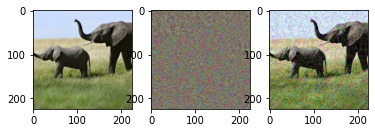

[('386, African_elephant', 95.10133361816406), ('101, tusker', 4.300267696380615), ('385, Indian_elephant', 0.5597339272499084), ('346, water_buffalo', 0.018703633919358253), ('343, warthog', 0.00771339563652873)]


[('101, tusker', 60.36949920654297),
 ('386, African_elephant', 31.127342224121094),
 ('385, Indian_elephant', 3.277179718017578),
 ('51, triceratops', 2.460554838180542),
 ('48, Komodo_dragon', 0.7402220964431763)]

In [ ]:
imshow_compare(batch_t[0], perturbed_image[0])
#original output
or_percentage = torch.nn.functional.softmax(original_output, dim=1)[0] * 100
_, or_indices = torch.sort(original_output, descending=True)
print([(classes[idx], or_percentage[idx].item()) for idx in or_indices[0][:5]])

#perturbed_output
per_percentage = torch.nn.functional.softmax(perturbed_output, dim=1)[0] * 100
_, per_indices = torch.sort(perturbed_output, descending=True)
[(classes[idx], per_percentage[idx].item()) for idx in per_indices[0][:5]]

Convert the adversarial image into a torch tensor

In [ ]:
np.save('im_array1',perturbed_image[0].cpu().numpy())
image5 = np.load('im_array1.npy')
image6 = torch.tensor(image5)
#imshow(image6)

Get the adversarial image

In [ ]:
import torchvision.transforms.functional as F
img1 = inv_normalize(perturbed_image[0])
img2 = img1.clamp(0,1)
pil_image = F.to_pil_image(img2)

Save the adversarial image

In [ ]:
#save a image using extension
im1 = pil_image.save("adv0.4.jpg")

**DEEPFOOL**

In [ ]:
original_output, perturbed_output, perturbed_image = GAE.deep_fool(model, batch_t, 10, torch.device('cuda'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


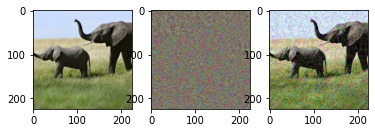

[('386, African_elephant', 95.10133361816406), ('101, tusker', 4.300267696380615), ('385, Indian_elephant', 0.5597339272499084), ('346, water_buffalo', 0.018703633919358253), ('343, warthog', 0.00771339563652873)]


[('101, tusker', 60.36949920654297),
 ('386, African_elephant', 31.127342224121094),
 ('385, Indian_elephant', 3.277179718017578),
 ('51, triceratops', 2.460554838180542),
 ('48, Komodo_dragon', 0.7402220964431763)]

In [ ]:
imshow_compare(batch_t[0], perturbed_image[0])
#original output
or_percentage = torch.nn.functional.softmax(original_output, dim=1)[0] * 100
_, or_indices = torch.sort(original_output, descending=True)
print([(classes[idx], or_percentage[idx].item()) for idx in or_indices[0][:5]])

#perturbed_output
per_percentage = torch.nn.functional.softmax(perturbed_output, dim=1)[0] * 100
_, per_indices = torch.sort(perturbed_output, descending=True)
[(classes[idx], per_percentage[idx].item()) for idx in per_indices[0][:5]]

Convert the adversarial image into a torch tensor

In [ ]:
np.save('im_array1',perturbed_image[0].cpu().numpy())
image7 = np.load('im_array1.npy')
image8 = torch.tensor(image7)
#imshow(image8)

Get the adversarial image

In [ ]:
import torchvision.transforms.functional as F
img1 = inv_normalize(perturbed_image[0])
img2 = img1.clamp(0,1)
pil_image = F.to_pil_image(img2)

Save the adversarial image

In [ ]:
#save a image using extension
#im1 = pil_image.save("it1_drum.jpg")
#im1 = pil_image.save("it3_drum.jpg")
im1 = pil_image.save("it10.jpg")

**Basic Iterative Method (BIM)**

In [ ]:
original_output, perturbed_output, perturbed_image = GAE.basic_iterative( model, batch_t, alpha=0.5, epsilon=10, num_iter=None, device=torch.device('cuda'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


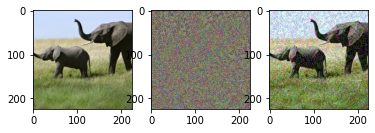

[('386, African_elephant', 95.10133361816406), ('101, tusker', 4.300267696380615), ('385, Indian_elephant', 0.5597339272499084), ('346, water_buffalo', 0.018703633919358253), ('343, warthog', 0.00771339563652873)]


[('8, hen', 91.32244110107422),
 ('618, ladle', 3.919727087020874),
 ('788, shoe_shop', 1.87147855758667),
 ('136, European_gallinule', 0.5705309510231018),
 ('7, cock', 0.4020255208015442)]

In [ ]:
imshow_compare(batch_t[0], perturbed_image[0])
#original output
or_percentage = torch.nn.functional.softmax(original_output, dim=1)[0] * 100
_, or_indices = torch.sort(original_output, descending=True)
print([(classes[idx], or_percentage[idx].item()) for idx in or_indices[0][:5]])

#perturbed_output
per_percentage = torch.nn.functional.softmax(perturbed_output, dim=1)[0] * 100
_, per_indices = torch.sort(perturbed_output, descending=True)
[(classes[idx], per_percentage[idx].item()) for idx in per_indices[0][:5]]

Convert the adversarial image into a torch tensor



In [ ]:
np.save('im_array1',perturbed_image[0].cpu().numpy())
image9 = np.load('im_array1.npy')
image10 = torch.tensor(image9)
#imshow(image10)

Get the adversarial image

In [ ]:
import torchvision.transforms.functional as F
img1 = inv_normalize(perturbed_image[0])
img2 = img1.clamp(0,1)
pil_image = F.to_pil_image(img2)

Save the adversarial image

In [ ]:
#save a image using extension
im1 = pil_image.save("bim5.jpg")

**Iterative Least Likely Method**

In [ ]:
original_output, perturbed_output, perturbed_image = GAE.iterative_ll_class( model, batch_t, alpha=0.5, epsilon=10, num_iter=None, device=torch.device('cuda'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


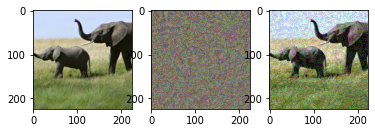

[('386, African_elephant', 95.10133361816406), ('101, tusker', 4.300267696380615), ('385, Indian_elephant', 0.5597339272499084), ('346, water_buffalo', 0.018703633919358253), ('343, warthog', 0.00771339563652873)]


[('333, hamster', 99.96855163574219),
 ('338, guinea_pig', 0.02545725740492344),
 ('332, Angora', 0.004093953408300877),
 ('330, wood_rabbit', 0.0009182131034322083),
 ('8, hen', 0.00029111694311723113)]

In [ ]:
imshow_compare(batch_t[0], perturbed_image[0])
#original output
or_percentage = torch.nn.functional.softmax(original_output, dim=1)[0] * 100
_, or_indices = torch.sort(original_output, descending=True)
print([(classes[idx], or_percentage[idx].item()) for idx in or_indices[0][:5]])

#perturbed_output
per_percentage = torch.nn.functional.softmax(perturbed_output, dim=1)[0] * 100
_, per_indices = torch.sort(perturbed_output, descending=True)
[(classes[idx], per_percentage[idx].item()) for idx in per_indices[0][:5]]

Convert the adversarial image into a torch tensor

In [ ]:
np.save('im_array1',perturbed_image[0].cpu().numpy())
image11 = np.load('im_array1.npy')
image12 = torch.tensor(image11)
#imshow(image12)

Get the adversarial image

In [ ]:
import torchvision.transforms.functional as F
img1 = inv_normalize(perturbed_image[0])
img2 = img1.clamp(0,1)
pil_image = F.to_pil_image(img2)

Save the adversarial image

In [ ]:
#save a image using extension
im1 = pil_image.save("ill.jpg")

**XAI METHODS**

**Grad CAM**

In [ ]:
!git clone https://github.com/omarsayed7/Grad-CAM

Cloning into 'Grad-CAM'...
remote: Enumerating objects: 63, done.
remote: Counting objects: 100% (63/63), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 63 (delta 25), reused 42 (delta 11), pack-reused 0
Unpacking objects: 100% (63/63), done.


In [ ]:
import torch
from torchvision import datasets, models, transforms
from torchsummary import summary 
from PIL import Image
import matplotlib.pyplot as plt
import cv2 
import numpy as np 

from grad_cam_pytorch import Torch_GradCam

In [ ]:
model_res = models.resnet50(pretrained=True)
summary(model_res.cuda(), (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]           4,096
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
           Conv2d-11          [-1, 256, 64, 64]          16,384
      BatchNorm2d-12          [-1, 256, 64, 64]             512
           Conv2d-13          [-1, 256, 64, 64]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
from grad_cam_pytorch import Torch_GradCam
model_res = models.resnet50(pretrained=True)
cam = Torch_GradCam(model_res,'layer4')

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


2048
Class ID: 333


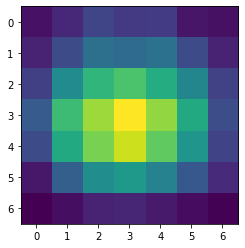

In [ ]:
heatmap = cam.generate_heatmap(image12[None])
s_map = cam.visualize_heatmap(heatmap, img_path='ill.jpg')
print("Class ID:",cam.get_output_class())
plt.imshow(heatmap)

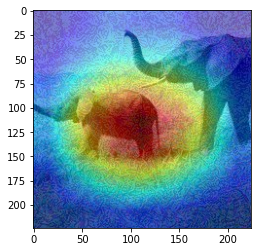

In [ ]:
plt.imshow(s_map)

**RISE**

In [ ]:
!git clone https://github.com/eclique/RISE

Cloning into 'RISE'...
remote: Enumerating objects: 22, done.
remote: Total 22 (delta 0), reused 0 (delta 0), pack-reused 22
Unpacking objects: 100% (22/22), done.


In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torchvision.datasets as datasets
import torchvision.models as models
from torch.nn.functional import conv2d

from utils import *
from evaluation import CausalMetric, auc, gkern
from explanations import RISE

cudnn.benchmark = True

In [ ]:
# Load black box model for explanations
#model = models.vgg19(True)
model = models.resnet50(True)
model = nn.Sequential(model, nn.Softmax(dim=1))
model = model.eval()
model = model.cuda()

for p in model.parameters():
    p.requires_grad = False
    
# To use multiple GPUs
model = nn.DataParallel(model)

In [ ]:
klen = 11
ksig = 5
kern = gkern(klen, ksig)

# Function that blurs input image
blur = lambda x: nn.functional.conv2d(x, kern, padding=klen//2)

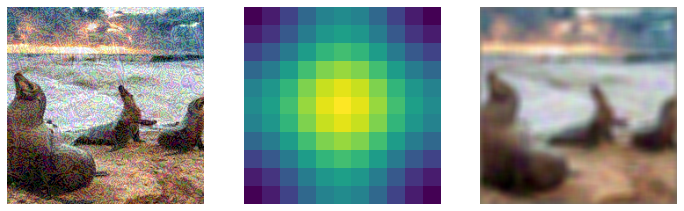

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.axis('off')
img = image12[None]
tensor_imshow(img[0])

plt.subplot(132)
plt.axis('off')
plt.imshow(kern[0, 0])

plt.subplot(133)
plt.axis('off')
tensor_imshow(blur(img)[0])
plt.show()

In [ ]:
insertion = CausalMetric(model, 'ins', 224, substrate_fn=blur)
deletion = CausalMetric(model, 'del', 224, substrate_fn=torch.zeros_like)

In [ ]:
explainer = RISE(model, (224, 224))
explainer.generate_masks(N=5000, s=10, p1=0.1)

Generating filters: 100%|██████████| 5000/5000 [00:22<00:00, 225.26it/s]


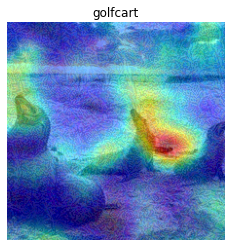

In [ ]:
# input the class class
sal = explainer(img.cuda())[575].cpu().numpy()
tensor_imshow(img[0])
plt.axis('off')
plt.title(get_class_name(575))
plt.imshow(sal, cmap='jet', alpha=0.5)
plt.show()